In [0]:
# get CPU and GPU info
! nvidia-smi
! nproc --all

In [0]:
# install pytorch and torchaudio
! pip install torchaudio

In [0]:
# debugging
! pip install line_profiler
%load_ext line_profiler
# plot inline
%matplotlib inline

In [0]:
# get training data
! git clone https://github.com/winstonwzhang/spoken_digit_classify

In [0]:
# collect garbage (free up RAM if parallel workers fail during training)
import gc
gc.collect()

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [0]:
import os
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import librosa.effects
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


# default data hyperparameters
class conf:
    sr = 8000  # sampling rate
    duration = 2.3  # how long input samples to our model should be
    hop_length = int(sr * 0.0115)  # step size half of frame
    fmin = 0.0
    fmax = 22050.0  # freq range of human speech
    n_mels = 25  # number of mfcc coefficients
    n_fft = int(sr * 0.023)  # frames of 0.023 sec
    padmode = 'constant'
    samples = sr * duration
    aug_probs = {'noise': 0.7,
                 'pitch': 0.3,
                 'speed': 0.7,
                 'shift': 0.8}  # prob of augment being applied


class Transform:
    '''Audio data augmentation class.'''
    def __init__(self, conf, wav):
        self.wav = wav
        self.conf = conf
    
    def run_transforms(self):
        x = self.wav
        if random.uniform(0, 1) < self.conf.aug_probs['pitch']:
            x = self.pitch_shift(x)
        if random.uniform(0, 1) < self.conf.aug_probs['speed']:
            x = self.speed_change(x)
        return x
    
    def add_noise(self, wav):
        if random.uniform(0, 1) < self.conf.aug_probs['noise']:
            noise = np.random.normal(size=len(wav))
            factor = 0.005 * random.uniform(0, 1) * max(wav)
            return wav + factor * noise
        else:
            return wav
    
    def pitch_shift(self, wav):
        pitch_pm = 2
        pitch_change = pitch_pm * 2 * random.uniform(0, 1)
        return librosa.effects.pitch_shift(
            wav, self.conf.sr, n_steps=pitch_change)
    
    def speed_change(self, wav):
        factor = np.random.normal(1, 0.2, 1)
        tmp = librosa.effects.time_stretch(wav, factor)
        minlen = min(wav.shape[0], tmp.shape[0])
        wav += 0
        wav[0:minlen] = tmp[0:minlen]
        return wav


def pad_audio(conf, audio, transform):
    # pad or cut audio to same length as conf.samples
    if len(audio) > conf.samples:
        audio = audio[0:0+conf.samples]
    elif len(audio) < conf.samples: # pad blank
        padding = conf.samples - len(audio)    # add padding at both ends
        if transform and random.uniform(0, 1) < conf.aug_probs['shift']:
            offset = random.randint(0, padding)
        else:
            offset = math.ceil(padding // 2)
        # random shift of audio (speech not always in center of spectrogram)
        padwidth = (offset, math.ceil(padding - offset))
        audio = np.pad(audio, padwidth, conf.padmode)
    return audio
  
def audio_to_mfcc(conf, audio):
    spectrogram = librosa.feature.mfcc(audio, 
                                       sr=conf.sr,
                                       n_mfcc=conf.n_mels,
                                       hop_length=conf.hop_length,
                                       n_fft=conf.n_fft,
                                       fmin=conf.fmin,
                                       fmax=conf.fmax)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def show_mfcc(conf, mels, title='MFCC'):
    librosa.display.specshow(mels,
                             x_axis='time',
                             sr=conf.sr,
                             hop_length=conf.hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def read_as_mfcc(conf, pathname, transform):
    # librosa slow to load for some reason
    x, _ = torchaudio.load(pathname)
    x = x[0, :].detach().numpy()
    # apply audio data augmentations (pitch, speed)
    if transform:
        tr = Transform(conf, x)
        x = tr.run_transforms()
    # padding for uniform input length
    x = pad_audio(conf, x, transform)
    # add noise to simulate realistic conditions
    if transform:
        x = tr.add_noise(x)
    # get mfccs
    mfcc = audio_to_mfcc(conf, x)
    # show_mfcc(conf, mfcc)
    return mfcc


class Digit_Dataset(Dataset):
    '''Dataset class that pads and converts a sample into mfcc.'''
    def __init__(self, wav_dir, transform=True):
        self.wav_dir = wav_dir
        self.data = os.listdir(wav_dir)
        # keep only .wav files
        self.data = [s for s in self.data if '.wav' in s]
        self.labels = [int(s[0]) for s in self.data]
        self.transform = transform
          
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        with torch.no_grad():
            wav_name = self.data[idx]
            label = self.labels[idx]

            mfcc_data = read_as_mfcc(
                conf, self.wav_dir + wav_name, self.transform)
            
            # normalize mfcc coefficients within each sample
            mfcc_mean = np.mean(mfcc_data, axis=1)
            mfcc_std = np.std(mfcc_data, axis=1)
            
            # broadcast across all time frames
            mfcc_mean = mfcc_mean[:, np.newaxis]
            mfcc_std = mfcc_std[:, np.newaxis]
            mfcc_data = (mfcc_data - mfcc_mean) / mfcc_std
            
            img = torch.from_numpy(mfcc_data)
            img = img.unsqueeze_(0) # add singleton dimension

            sample = {'img': img, 'label': label}

            return sample
    
    def visualize_labels(self, transform=True):
        for i in range(4):
            idx = self.labels.index(i)
            mfcc = read_as_mfcc(conf, self.wav_dir + self.data[idx], transform)
            plt.subplot(2, 2, i+1)
            librosa.display.specshow(mfcc,
                                     x_axis='time',
                                     sr=conf.sr,
                                     hop_length=conf.hop_length)
            plt.colorbar(format='%+2.0f dB')
            plt.title(str(i))
        plt.tight_layout()
        plt.show()

        
#wav_dir = 'recordings/'
#db = Digit_Dataset(wav_dir, transform=True)
#%lprun -f librosa.core.phase_vocoder db[20]

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class BaseModel(nn.Module):
  '''Main neural net model.'''
  def __init__(self):
    super(BaseModel, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(24)
    self.pool1 = nn.MaxPool2d(kernel_size=(1, 2))
    
    self.conv2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3)
    self.conv2o = nn.Conv2d(in_channels=48, out_channels=24, kernel_size=1)
    self.bn2 = nn.BatchNorm2d(24)
    self.pool2 = nn.MaxPool2d(kernel_size=(1, 2))
    
    self.conv3 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3)
    self.conv3o = nn.Conv2d(in_channels=48, out_channels=24, kernel_size=1)
    self.bn3 = nn.BatchNorm2d(24)
    self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
    
    self.drop1 = nn.Dropout(p=0.2)
    self.fc1 = nn.Linear(in_features=4968, out_features=1024)
    self.drop2 = nn.Dropout(p=0.2)
    self.fc2 = nn.Linear(in_features=1024, out_features=64)
    self.fc3 = nn.Linear(in_features=64, out_features=10)

  def forward(self, x):
    
    x = F.relu(self.conv1(x))
    x = self.pool1(self.bn1(x))
    
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv2o(x))
    x = self.pool2(self.bn2(x))
    
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv3o(x))
    x = self.pool3(self.bn3(x))
    
    x = torch.flatten(x, start_dim=1)
    
    x = self.drop1(x)
    x = F.relu(self.fc1(x))
    
    x = self.drop2(x)
    x = F.relu(self.fc2(x))
    
    x = self.fc3(x)
    return x

In [70]:
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
#import utils
#from utils import data
#from utils import model as mdl


########### Hyper-parameters #####################
class hp:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    lr = 3e-4  # learning rate
    num_epochs = 50
    batch_size = 50
    validation_split = .2
    shuffle_dataset = True
    random_seed = 42
    num_w = 8  # number of parallel workers
    weight_decay = 1e-3
    

print(hp.device)

wav_dir = 'spoken_digit_classify/recordings/'
save_path = 'fsdd_cnn_sdict.pt'

########### Load data #####################
train_db = Digit_Dataset(wav_dir, transform=True)
val_db = Digit_Dataset(wav_dir, transform=False)

dataset_size = len(train_db.labels)
indices = list(range(dataset_size))
split = int(np.floor(hp.validation_split * dataset_size))

if hp.shuffle_dataset :
    np.random.seed(hp.random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]
test_indices = val_indices[:len(val_indices) // 2]
val_indices = val_indices[len(val_indices) // 2:]  # split into val and test

num_train = len(train_indices)
num_val = len(val_indices)
num_test = len(test_indices)

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_dataloader = DataLoader(train_db, batch_size=hp.batch_size, 
                              sampler=train_sampler, num_workers=hp.num_w)
val_dataloader = DataLoader(val_db, batch_size=hp.batch_size,
                            sampler=valid_sampler, num_workers=hp.num_w)
test_dataloader = DataLoader(val_db, batch_size=hp.batch_size,
                            sampler=test_sampler, num_workers=hp.num_w)

############## Initialize Weights #######################
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


############## Main Function #######################
def run():
    model = BaseModel().double() # Creating the model
    model.apply(init_weights)

    model = model.to(hp.device)

    criterion = nn.CrossEntropyLoss().to(hp.device)
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=hp.lr,
                                 weight_decay=hp.weight_decay)
        
    # train!
    result = train(model, criterion, optimizer)
    print(result)
    # test
    test_acc, test_loss = val(model, criterion, test_dataloader)
    print('test_acc:{}, test_loss:{}'.format(test_acc, test_loss))


############ Validation function #############
def val(model, criterion, dl):
    with torch.no_grad():
      
        print('Validation starts !!!')
        
        running_corrects = 0
        loss_sum = 0.0
        
        for it, data in enumerate(dl):
            #if it % 10 == 0:
            #    print(it)
            inp = data['img']
            target = data['label']

            inp = inp.double().to(hp.device)
            target = target.to(hp.device)
            model = model.to(hp.device)

            # ===================forward=====================
            output = model(inp)
            loss = criterion(output, target)
            loss_sum += loss.item()
            _, preds = torch.max(output, 1)
            running_corrects += (preds == target.data).sum().cpu().numpy()

        acc = running_corrects / num_val
        loss_sum = loss_sum / len(dl)
        print('Accuracy:{0}, Loss:{1}'.format(acc, loss_sum))
        return acc, loss_sum


############ Training function ###################
def train(model, criterion, optimizer):
    print('Initial validation:')
    val(model, criterion, val_dataloader)

    print('Training starts !!!')
    tr_losses=[]
    tr_accs = []
    val_losses=[]
    val_accs = []
    best_epoch = 0
    best_acc = 0.0
    
    for epoch in range(hp.num_epochs):
        start = time.time()
        
        model.train()  # train mode

        running_corrects = 0
        loss_sum = 0.0

        for it,data in enumerate(train_dataloader):
            #if it % 10 == 0:
            #  print(it)
            inp = data['img']
            target = data['label']

            inp = inp.double().to(hp.device)
            target = target.to(hp.device)
            model = model.to(hp.device)
            # ===================forward=====================
            output = model(inp)
            loss = criterion(output, target)
            loss_sum += loss.item()
            _, preds = torch.max(output, 1)
            running_corrects += (preds == target.data).sum().cpu().numpy()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()  # eval mode
        
        duration = time.time() - start
        loss_sum = loss_sum / len(train_dataloader)
        tr_acc = running_corrects / num_train
        print('epoch [{}/{}], Tr loss:{:.4f} Tr Acc:{:.4f} Time:{:.4f}'.format(
            epoch+1, hp.num_epochs, loss_sum, tr_acc, duration))
        tr_losses.append(loss_sum)
        tr_accs.append(tr_acc)

        val_acc, val_loss = val(model, criterion, val_dataloader)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
    
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch + 1
            # save model
            torch.save(model.state_dict(), save_path)
    
    # save accs and loss
    np.save('tr_accs.npy', np.array(tr_accs))
    np.save('val_accs.npy', np.array(val_accs))
    np.save('train_losses.npy', np.array(tr_losses))
    np.save('val_losses.npy', np.array(val_losses))
    
    return {'best_epoch': best_epoch, 'best_acc': best_acc}

cuda:0


In [71]:
run()

Initial validation:
Validation starts !!!
Accuracy:0.09, Loss:4.289728345232753
Training starts !!!
epoch [1/50], Tr loss:2.6367 Tr Acc:0.1131 Time:32.1737
Validation starts !!!
Accuracy:0.18, Loss:2.2100493095886344
epoch [2/50], Tr loss:2.2567 Tr Acc:0.1425 Time:32.6931
Validation starts !!!
Accuracy:0.29, Loss:1.9649508203539836
epoch [3/50], Tr loss:2.0259 Tr Acc:0.2369 Time:33.1298
Validation starts !!!
Accuracy:0.42, Loss:1.4007535100892547
epoch [4/50], Tr loss:1.7329 Tr Acc:0.3387 Time:31.9949
Validation starts !!!
Accuracy:0.475, Loss:1.2984471052730575
epoch [5/50], Tr loss:1.5442 Tr Acc:0.4037 Time:31.3316
Validation starts !!!
Accuracy:0.66, Loss:1.031568164478692
epoch [6/50], Tr loss:1.3283 Tr Acc:0.5044 Time:32.0898
Validation starts !!!
Accuracy:0.69, Loss:0.8223597768859096
epoch [7/50], Tr loss:1.1889 Tr Acc:0.5606 Time:31.1576
Validation starts !!!
Accuracy:0.735, Loss:0.622147395600277
epoch [8/50], Tr loss:1.0573 Tr Acc:0.6088 Time:31.0091
Validation starts !!!
Acc

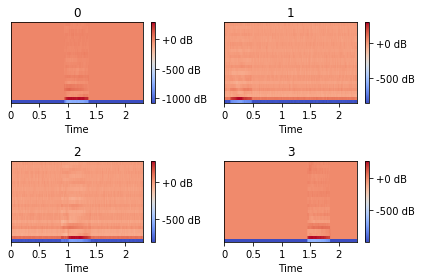

In [72]:
train_db.visualize_labels(transform=True)

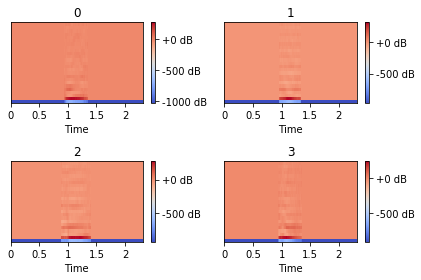

In [73]:
val_db.visualize_labels(transform=False)

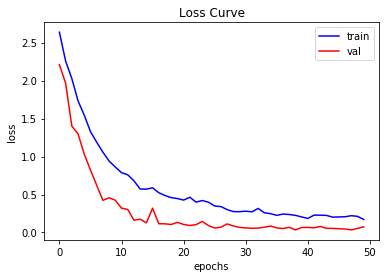

In [74]:
import matplotlib.pyplot as plt

plt.clf()

train_losses = np.load('train_losses.npy')
val_losses = np.load('val_losses.npy')

plt.plot(np.arange(hp.num_epochs), train_losses, 'b', label='train')
plt.plot(np.arange(hp.num_epochs), val_losses, 'r', label='val')
plt.title('Loss Curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

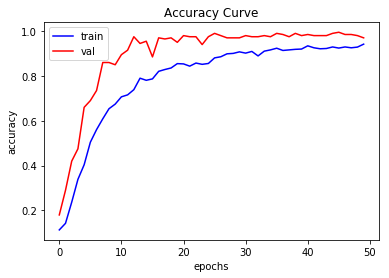

In [75]:
plt.clf()

tr_accs = np.load('tr_accs.npy')
val_accs = np.load('val_accs.npy')

plt.plot(np.arange(hp.num_epochs), tr_accs, 'b', label='train')
plt.plot(np.arange(hp.num_epochs), val_accs, 'r', label='val')
plt.title('Accuracy Curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()